In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
from fastai.dataset import *

from pathlib import Path
import json

/home/ray/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
torch.cuda.is_available()

True

In [4]:
torch.backends.cudnn.enabled

True

In [5]:
PATH = Path('/home/ray/fastai/courses/dl2/QBI/data')
os.listdir(PATH)

['cell_data.h5',
 'validation',
 'tmp',
 'hackathon',
 'hackathon_unet.tar',
 'train',
 'segnet_validation.zip',
 'models']

In [6]:
sz = 512
bs = 8
nw = 4

In [7]:
TRAIN_DATA_x = '{}/train/'.format(PATH)
TRAIN_DATA_y = '{}/train/masks'.format(PATH)
trn_x = glob(os.path.join(TRAIN_DATA_x, "*.jpg"))
trn_y = glob(os.path.join(TRAIN_DATA_y, "*.jpg"))

In [8]:
TRAIN_DATA_y

'/home/ray/fastai/courses/dl2/QBI/data/train/masks'

In [9]:
!ls {TRAIN_DATA_x} | wc -l

1635


In [10]:
VALID_DATA_x = '{}/validation/images'.format(PATH)
VALID_DATA_y = '{}/validation/masks'.format(PATH)
val_x = glob(os.path.join(VALID_DATA_x, "*.jpg"))
val_y = glob(os.path.join(VALID_DATA_y, "*.jpg"))

In [11]:
img = Image.open(trn_x[0])
np.asarray(img).shape

(512, 512)

In [12]:
img = Image.open(trn_y[0])
np.asarray(img).shape

(512, 512)

In [13]:
print('Len train set: {} len train mask: {}'.format(len(trn_x), len(trn_y)))
print('Len valid set: {} Len Valid mask: {}'.format(len(val_x), len(val_y)))

Len train set: 1616 len train mask: 1616
Len valid set: 1616 Len Valid mask: 1616


In [14]:
class MatchedFilesDataset(FilesDataset):
    def __init__(self, fnames, y, transform, path):
        self.y=y
        assert(len(fnames)==len(y))
        super().__init__(fnames, transform, path)
    def get_y(self, i): return open_image(os.path.join(self.path, self.y[i]))
    def get_c(self): return 0

In [15]:
aug_tfms = [RandomRotate(4, tfm_y=TfmType.CLASS),
            RandomFlip(tfm_y=TfmType.CLASS),
            RandomLighting(0.05, 0.05, tfm_y=TfmType.CLASS)]

In [16]:
tfms = tfms_from_model(resnet34, sz, crop_type=CropType.RANDOM, tfm_y=TfmType.NO, aug_tfms=transforms_top_down)
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path=PATH)
md = ImageData(PATH, datasets, bs, num_workers=16, classes=None)
denorm = md.trn_ds.denorm

In [17]:
denorm = md.trn_ds.denorm
x,y = next(iter(md.aug_dl))
x = denorm(x)
y = to_np(y)

y[0].shape

(512, 512, 3)

In [18]:
def show_img(im, figsize=None, ax=None, alpha=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha)
    ax.set_axis_off()
    return ax

In [19]:
f = resnet34
cut,lr_cut = model_meta[f]

In [20]:
def get_base():
    layers = cut_model(f(True), cut)
    return nn.Sequential(*layers)

In [21]:
def mask_loss(pred,targ):
    return F.binary_cross_entropy_with_logits(pred[:,0],targ[...,0])

def mask_acc(pred,targ): return accuracy_multi(pred[:,0], targ[...,0], 0.)

In [22]:
def dice(pred, targs):
    m1 = (pred[:,0]>0).float()
    m2 = targs[...,0]
    return 2. * (m1*m2).sum() / (m1+m2).sum()

In [23]:
class StdUpsample(nn.Module):
    def __init__(self, nin, nout):
        super().__init__()
        self.conv = nn.ConvTranspose2d(nin, nout, 2, stride=2)
        self.bn = nn.BatchNorm2d(nout)
        
    def forward(self, x): return self.bn(F.relu(self.conv(x)))

In [24]:
class Upsample34(nn.Module):
    def __init__(self, rn):
        super().__init__()
        self.rn = rn
        self.up1 = StdUpsample(512,256)
        self.up2 = StdUpsample(256,256)
        self.up3 = StdUpsample(256,256)
        self.up4 = StdUpsample(256,256)
        self.up5 = nn.ConvTranspose2d(256, 1, 2, stride=2)
        
    def forward(self,x):
        x = F.relu(self.rn(x))
        x = self.up1(x)
        x = self.up2(x)
        x = self.up3(x)        
        x = self.up4(x)
        x = self.up5(x)
        return x

In [25]:
m_base = get_base()

In [26]:
class UpsampleModel():
    def __init__(self,model,name='upsample'):
        self.model,self.name = model,name

    def get_layer_groups(self, precompute):
        lgs = list(split_by_idxs(children(self.model.rn), [lr_cut]))
        return lgs + [children(self.model)[1:]]

In [27]:
m = to_gpu(Upsample34(m_base))
models = UpsampleModel(m)

In [28]:
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam
learn.crit=mask_loss
learn.metrics=[mask_acc,dice]

In [28]:
learn.freeze_to(1)

 81%|████████  | 163/202 [01:10<00:16,  2.30it/s, loss=2.47] 

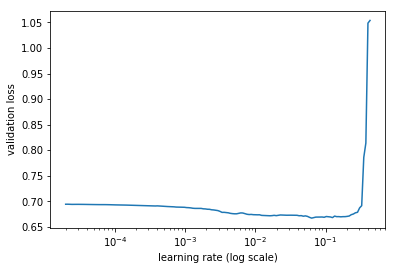

In [29]:
learn.lr_find()
learn.sched.plot()

In [31]:
#TODO Implement differential learning rates
lr=10e-1
wd = 1e-7
lrs = np.array([lr/100,lr/10,lr])/2

In [31]:
learn.fit(lr,1,wds = wd, cycle_len=4,use_clr=(20,8))

epoch      trn_loss   val_loss   mask_acc   dice             
    0      2.579828   0.737504   0.52206    0.746872  
    1      0.729159   0.692749   0.53925    0.771444         
    2      0.672166   0.659458   0.538214   0.770015         
    3      0.658264   0.658635   0.53925    0.771444         


[array([0.65863]), 0.5392498970031738, 0.771443882658792]

In [32]:
learn.save('checkpoint_tmp')

In [29]:
learn.load('checkpoint_tmp')

In [32]:
# Differential learning fit
learn.unfreeze()
# learn.bn_freeze(True)
learn.fit(lrs,1,cycle_len=4,use_clr=(20,8))

epoch      trn_loss   val_loss   mask_acc   dice             
    0      0.774654   0.874233   0.375341   0.356263  
    1      0.957639   1.740168   0.53925    0.771444         
    2      0.686869   0.658774   0.53925    0.771444         
    3      0.664628   0.658981   0.53925    0.771444         



[array([0.65898]), 0.5392498970031738, 0.771443882658792]

In [33]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


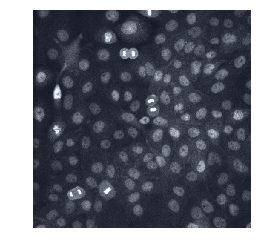

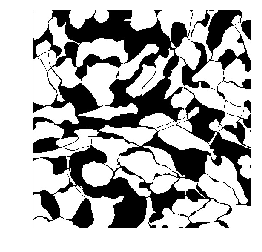

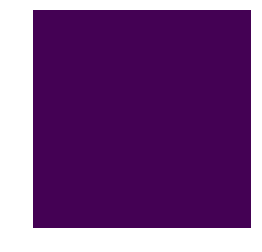

In [34]:
show_img((x[3,:].transpose(0,2).transpose(0,1)+2.5)/5)
show_img(y[3])
show_img(py[3][0]>0);